In [1]:
import pickle
with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# Function to compute cross product of two 2D vectors
def cross_product_2d(a, b):
    """ Computes the 2D cross product (scalar in 2D)."""
    return a[0] * b[1] - a[1] * b[0]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points on the Earth (specified in decimal degrees).
    This uses the Haversine formula to compute distance over a sphere.
    
    Parameters:
        lon1, lat1, lon2, lat2: Coordinates of the two points (in degrees).
        
    Returns:
        distance: Distance between the two points in meters (or chosen units if using a different radius).
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of Earth in meters (mean value, can adjust as needed)
    r = 6371000  
    return c * r

def compute_LNAM(lon_rho, lat_rho, V, grid_size=5):
    """
    Compute the Local and Normalized Angular Momentum (LNAM) for a 2D grid of points.
    The grid is not evenly spaced and can be rotated, so we use actual geographical coordinates (lon_rho, lat_rho).
    
    Parameters:
        lon_rho (ndarray): Array of longitudes (n x m grid).
        lat_rho (ndarray): Array of latitudes (n x m grid).
        V (ndarray): Array of velocity vectors (n x m x 2), where each element is [u, v].
        grid_size (int): Size of the neighboring window, must be an odd number.
    
    Returns:
        LNAM (ndarray): Array of LNAM values for each grid point.
    """
    n, m = lon_rho.shape  # Get grid dimensions
    half_size = grid_size // 2
    LNAM = np.zeros((n, m))

    for i in range(half_size, n - half_size):
        for j in range(half_size, m - half_size):
            lon_i, lat_i = lon_rho[i, j], lat_rho[i, j]  # Longitude and latitude of grid point
            Vi = V[i, j]  # Velocity vector at grid point

            S = 0  # Sum of scalar products Si
            L = 0  # Local angular momentum Li
            B = 0  # Upper bound BLi

            # Iterate over the neighbors in the square grid
            for di in range(-half_size, half_size + 1):
                for dj in range(-half_size, half_size + 1):
                    if di == 0 and dj == 0:
                        continue  # Skip the center point itself

                    lon_j, lat_j = lon_rho[i + di, j + dj], lat_rho[i + di, j + dj]  # Neighbor coordinates
                    Vj = V[i + di, j + dj]  # Neighbor velocity

                    # Compute the distance between points using the Haversine formula
                    distance = haversine(lon_i, lat_i, lon_j, lat_j)

                    # Compute the difference in position vectors using lon/lat coordinates
                    diff_X = np.array([lon_i - lon_j, lat_i - lat_j])

                    # Local angular momentum: (Xi - Xj) x Vj
                    cross_product = diff_X[0] * Vj[1] - diff_X[1] * Vj[0]
                    L += cross_product

                    # Upper bound BLi: |Xi - Xj| * |Vj|
                    norm_Vj = np.linalg.norm(Vj)  # |Vj|
                    B += distance * norm_Vj

                    # Scalar product: (Xi - Xj) . Vj
                    scalar_product = np.dot(diff_X, Vj)
                    S += scalar_product

            # Compute LNAM at point Xi
            if B != 0:  # Avoid division by zero
                LNAM[i, j] = (L + S) / B

    return LNAM

def convert_uv_to_V(u, v):
    """
    Convert u and v matrices (velocity components) into the velocity vector field V.
    
    Parameters:
        u (ndarray): Matrix of x-direction velocities (shape n x m).
        v (ndarray): Matrix of y-direction velocities (shape n x m).
    
    Returns:
        V (ndarray): Velocity vector field (shape n x m x 2), where each element is a velocity vector [u_i, v_i].
    """
    # Check that the shapes of u and v match
    assert u.shape == v.shape, "u and v must have the same shape"
    
    # Stack u and v into the third dimension to create velocity vectors
    V = np.stack((u, v), axis=-1)
    
    return V


In [4]:
fnumber = '01461'
u_orig = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
u = u_orig[:,:,0,0].squeeze()
v_orig = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
v = v_orig[:,:,0,0].squeeze()

In [5]:
V = convert_uv_to_V(u, v)

# Compute the LNAM for the grid
lnam_values_all = compute_LNAM(lon_rho, lat_rho, V, grid_size=5)


In [6]:
from scipy.ndimage import minimum_filter, maximum_filter

def find_local_minima_maxima(LNAM):
    """
    Find the local minima and maxima in a matrix.
    
    Parameters:
        LNAM (ndarray): 2D array representing the LNAM matrix.
    
    Returns:
        minima (ndarray): Boolean matrix of the same shape as LNAM, where True indicates local minima.
        maxima (ndarray): Boolean matrix of the same shape as LNAM, where True indicates local maxima.
    """
    # Define neighborhood size for comparing neighbors
    neighborhood_size = 3  # 3x3 grid for neighbors comparison
    
    # Apply filters to find local minima and maxima
    local_min = minimum_filter(LNAM, size=neighborhood_size, mode='constant')
    local_max = maximum_filter(LNAM, size=neighborhood_size, mode='constant')
    
    # Find where the LNAM values are equal to the local min and max (minima/maxima)
    minima = (LNAM == local_min)
    maxima = (LNAM == local_max)
    
    return minima, maxima

# Find local minima and maxima
minima, maxima = find_local_minima_maxima(lnam_values_all)


(np.float64(147.1),
 np.float64(162.21804721948396),
 np.float64(-41.545855397466454),
 np.float64(-25.117712108547657))

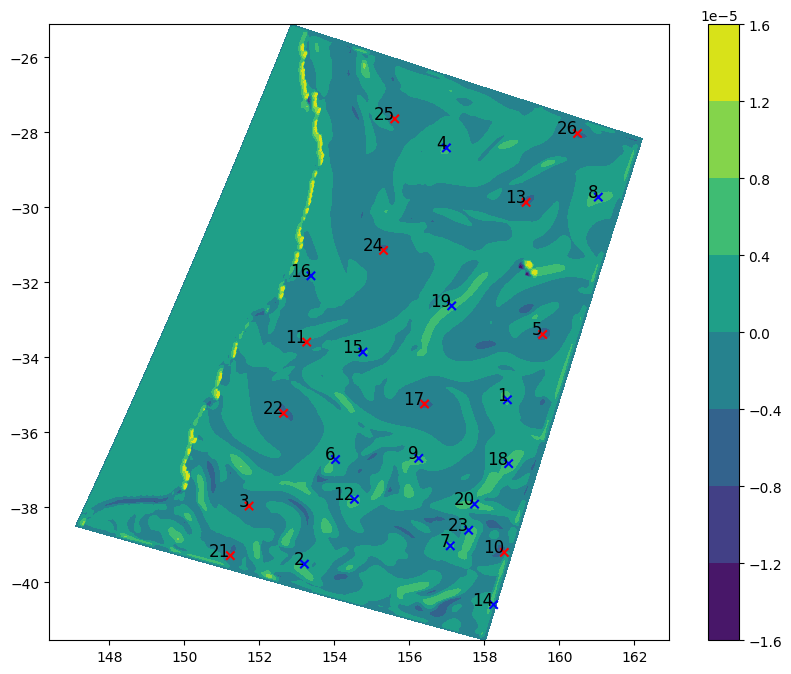

In [22]:
plt.figure(figsize=(10, 8))
plt.contourf(lon_rho, lat_rho, lnam_values_all)
plt.colorbar()
colors = ['r' if v > 0 else 'b' for v in daydic['Day1'].Vort]
plt.scatter(daydic['Day1'].Lon, daydic['Day1'].Lat, color=colors, marker='x')
# plt.scatter(lon_rho[minima], lat_rho[minima])

# i = 5
# plt.scatter(daydic['Day1'].Lon.iloc[i], daydic['Day1'].Lat.iloc[i], color='k')

# plt.text(daydic['Day1'].Lon, daydic['Day1'].Lat, str(round(daydic['Day1'].Id)))
for l, la, idd in zip(daydic['Day1'].Lon, daydic['Day1'].Lat, daydic['Day1'].Id):
    plt.text(l, la, str(round(idd)), fontsize=12, ha='right')

plt.axis('equal')

In [8]:
daydic['Day1'].iloc[16]

Lon     156.407397
Lat     -35.243929
Vort      0.000019
Id       17.000000
Age      23.000000
Name: Eddy17, dtype: float64

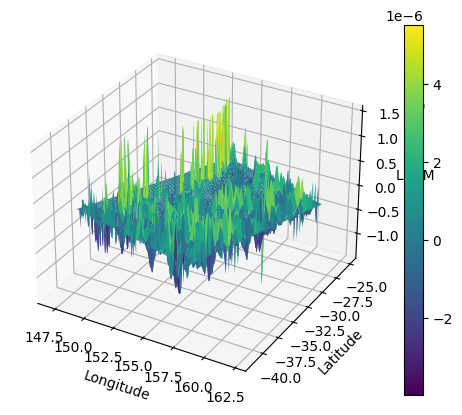

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure for surface plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface using lon_rho, lat_rho, and lnam_values
surf = ax.plot_surface(lon_rho, lat_rho, lnam_values_all, cmap='viridis')

# Add color bar for reference
fig.colorbar(surf)

# Set labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('LNAM')

plt.show()

## SAMPLE

In [11]:
def grid_finder(i_search, j_search, SEARCH_WIDTH):

    def distance(lat1, lon1, lat2, lon2):
        EARTH_RADIUS = 6357000
        lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
        lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
        dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
        a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
        return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

(np.float64(157.84095896151038),
 np.float64(160.31875170208352),
 np.float64(-30.981233626050482),
 np.float64(-28.68770792162261))

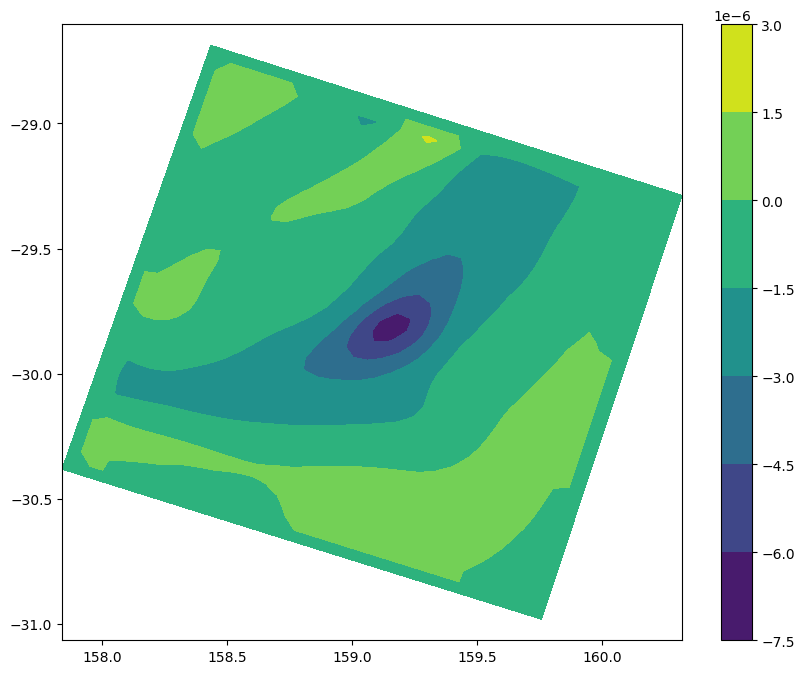

In [33]:
edata = daydic['Day1'].loc['Eddy13'] #E17. E4

SEARCH_WIDTH = 200000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

lon = lon_rho[i_left:i_right,j_down:j_up]
lat = lat_rho[i_left:i_right,j_down:j_up]

u_sample = u_orig[i_left:i_right,j_down:j_up,0,0].squeeze()
v_sample = v_orig[i_left:i_right,j_down:j_up,0,0].squeeze()
V_sample = convert_uv_to_V(u_sample, v_sample)

# Compute the LNAM for the grid
lnam_values = compute_LNAM(lon, lat, V_sample, grid_size=5)

plt.figure(figsize=(10, 8))
plt.contourf(lon, lat, lnam_values)
plt.colorbar()

plt.axis('equal')

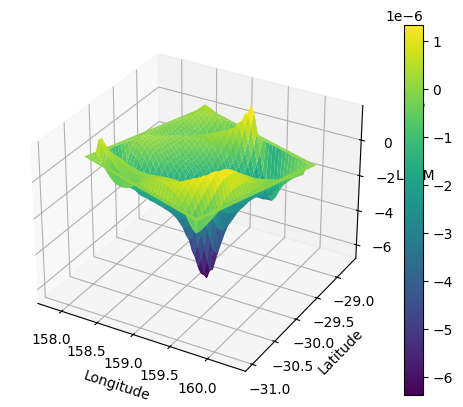

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure for surface plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface using lon_rho, lat_rho, and lnam_values
surf = ax.plot_surface(lon, lat, lnam_values, cmap='viridis')

# Add color bar for reference
fig.colorbar(surf)

# Set labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('LNAM')

plt.show()